In [2]:
import utils
from sklearn.model_selection import train_test_split
import lsh_random_projection as LSH
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lsh_random_projection as LSH

In [10]:
features = utils.load("data/fma_metadata/features.csv")
tracks = utils.load('data/fma_metadata/tracks.csv')

non_nulls_tracks = tracks[tracks['track']['genre_top'].notnull()]

print(non_nulls_tracks.head())

non_null_features = features.loc[non_nulls_tracks.index]

            album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
134             0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   

                                            ...       track           \
         information listens producer tags  ... information interest   
track_id                                    ...                        
2            <p></p>    6073      NaN   []  ...         NaN     4656   
3            <p></p>    6073      NaN   []  ...         NaN     1470   
5            <p></p>   

In [4]:
def build_model():



    X_train, X_test = train_test_split(non_null_features, test_size=1)
    lsh = LSH.LSH(1, 15, 140)
    lsh.add(X_train['mfcc'])
    
    obj = [lsh, X_train, X_test]

    save_object(obj, 'lsh.pkl')
    
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


In [5]:
# build_model()

In [6]:
with open('lsh.pkl', 'rb') as input:
    obj = pickle.load(input)
    # lsh.get()
    lsh = obj[0]
    X_train = obj[1]
    X_test = obj[2]
        
    results = lsh.get(X_test['mfcc'], probeType="rand_proj")
    print(results)


# print(X_test['mfcc'].head())

# res = lsh.get(X_test['mfcc'], probeType="rand_proj")


[        id          genre    distance
0    42447           Rock   97.966413
1    55448           Rock   98.489520
2    19413            Pop   98.734143
3    42472           Folk   99.899773
4    51313           Rock  100.119456
5    17595           Rock  100.605594
6    13596           Rock  101.146360
7   148158           Rock  101.902463
8    14413           Rock  102.990867
9   153208           Rock  103.754013
10    4076  International  103.943591
11   53974           Rock  104.486630
12  130013           Rock  105.078652
13   63194           Rock  105.330504
14   30156           Rock  105.484676
15   51317           Rock  105.530776
16   42466           Folk  105.894419
17   42464           Folk  105.994585
18   90301            Pop  106.649340
19  155300           Folk  106.659321]


Evaluation of accuracy with varying key-size

In [7]:
print(X_train['mfcc'].shape[1])

140


In [8]:
# get LSH structures, which vary by hash_key
def get_lshs_vary_hash_size():

    tables = []
    genre_acc = []
    recall_acc = []
    
    table_size = 40
    features_size =  X_train['mfcc'].shape[1]
    
    lsh_objs = []
    queries_list = []
    
 
        
    lsh = LSH.LSH(table_size, 1, features_size)   
    dataset, queries = train_test_split(non_null_features, test_size=100)
    lsh.add(dataset['mfcc'])    
    lsh_objs.append(lsh)
    queries_list.append(queries['mfcc'])
    
    for i in range(1, 20):

        lsh = LSH.LSH(table_size, i * 5, features_size)

        dataset, queries = train_test_split(non_null_features, test_size=100)
        lsh.add(dataset['mfcc'])    
        lsh_objs.append(lsh)
        queries_list.append(queries['mfcc'])
        
    return lsh_objs, queries_list

In [9]:
def bruteforce_get(features, inp_vec, k=20):

    query_top_ks = [None for i in range(len(inp_vec))]

    for idx in range(len(inp_vec)):

        distance = pairwise_distances(
            features, inp_vec.iloc[idx].values.reshape(1, -1), metric='euclidean').flatten()

        nearest_neighbours = pd.DataFrame({'id': features.index, 'genre': tracks['track']['genre_top'].loc[features.index], 'distance': distance}).sort_values(
            'distance').reset_index(drop=True)

        # print("nearest negih")
        # print(nearest_neighbours.head())

        candidate_set_labels = nearest_neighbours.sort_values(
            by=['distance'], ascending=True)

        non_null = candidate_set_labels[candidate_set_labels['genre'].notnull(
        )]

        query_top_ks[idx] = non_null.iloc[:k]

    return query_top_ks

In [10]:
# 
def get_recall_accuracy(lsh_list, queries_list, type="hash_size"):
    
    results = []
#     hash_sizes = []
    dependent_var = []
    
    for lsh, queries in zip(lsh_list, queries_list):
        

        top_ks = lsh.get(queries)
        brute_force_top_ks = bruteforce_get(non_null_features['mfcc'], queries)
        
        recall_sum = 0
        count = len(top_ks)
        
        for top_k, brute_force in zip(top_ks, brute_force_top_ks):
            
            recall = get_recall(brute_force['id'], top_k['id'])
            
            recall_sum += recall
            
        avg = recall_sum / count
        
        results.append(avg)
      
        if type == "hash_size":
            dependent_var.append(lsh.hash_size)   
        else:
            dependent_var.append(lsh.num_tables)
#     print(results)

    plt.plot(results, dependent_var,
         color='blue', marker='x', label="rand-proj")
    plt.grid(True)
    plt.legend(loc="upper right")
    print("tables ", dependent_var)
    print("results", results)
    plt.show()

    
            
def get_recall(ys, Ys):

    k = len(ys)
    if k == 0:
        return 0

    count = 0
    for Y in Ys:
        if (ys == Y).any():

            # print("FOUND ", Y)
            count = count + 1

    return count / k

tables  [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
results [0.9420000000000016, 0.9470000000000017, 0.8050000000000003, 0.4725000000000001, 0.06299999999999996, 0.025, 0.0015000000000000002, 0.002, 0.0, 0.0, 0.0015000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


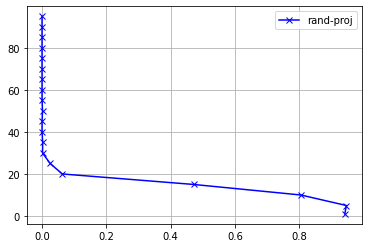

In [17]:
# lsh_list, query_list = get_lshs_vary_hash_size()
# print(len(a), len(b))
# for obj in lsh_list:
#     print(obj.hash_size)
get_recall_accuracy(lsh_list, query_list, "hash_size")

In [12]:
def get_lshs_vary_num_tables():
    
    hash_size = 15
    features_size =  X_train['mfcc'].shape[1]
    
    lsh_objs = []
    queries_list = []
    
 
        
    lsh = LSH.LSH(1, hash_size, features_size)   
    dataset, queries = train_test_split(non_null_features, test_size=100)
    lsh.add(dataset['mfcc'])    
    lsh_objs.append(lsh)
    queries_list.append(queries['mfcc'])
    
    for i in range(1, 20):

        lsh = LSH.LSH(i * 2, hash_size, features_size)

        dataset, queries = train_test_split(non_null_features, test_size=100)
        lsh.add(dataset['mfcc'])    
        lsh_objs.append(lsh)
        queries_list.append(queries['mfcc'])
        
    return lsh_objs, queries_list

In [13]:
lsh_tables_list, tables_queries_list = get_hashkey_lshs()
get_recall_accuracy(lsh_tables_list, tables_queries_list, "num_tables")

NameError: name 'lsb_obj' is not defined

In [88]:
X_train, X_test = train_test_split(non_null_features, test_size=2)
lsh = LSH.LSH(40, 15, 140)
lsh.add(X_train['mfcc'])




In [89]:
queries, query_matches = lsh.get(X_test['mfcc'], collision_ratio=0.5)

# print(inp_vec)

print(len(X_test))
print(len(query_matches[0]))

2
21


In [93]:

# evaluate accuracy of candidate sets vs expected genres for each query
def eval_candidates_genre_precision(queries, query_matches):
    
    
   
    
#     get genre of queries
    
#     print(tracks.index)
    ys = non_nulls_tracks[non_nulls_tracks.index.isin(queries.index)]['track']['genre_top']
    
    print("genres", ys)
    

    Ys = []
    
    for matches in query_matches:
        
#         get genre of candidate sets for each query
        Y = non_nulls_tracks[non_nulls_tracks.index.isin(matches)]['track']['genre_top']
        
        Ys.append(Y)
        
    sum = 0
        
    for y, Y in zip(ys, Ys):
        
        print(" total ", len(Y))
        
        correct_hashes = Y[Y == y]
        
        print("correct hashes", len(correct_hashes))
        
        prec = len(correct_hashes) / len(Y)
        sum += prec
        
    precision = sum / len(ys)
    return precision

    
    
    
        
    
    
    
    

In [94]:
def eval_candidates_genre_recall(queries, dataset, query_matches):
    
    
   
    
#     get genre of queries
    expected_genres = non_nulls_tracks[non_nulls_tracks.index.isin(queries.index)]['track']['genre_top']
    
    
    dataset_tracks =  non_nulls_tracks[non_nulls_tracks.index.isin(dataset.index)]
    

    sum = 0
    count = 0
    for g, candidates in zip(expected_genres, query_matches):
        
#         get all tracks in dataset with same genre
        y = len(dataset_tracks[dataset_tracks['track']['genre_top'] == g])
        print("expected number", y)
    
        
#         Y = qu
        # get matches with have same genre as g
        candidates_genres = dataset_tracks[dataset_tracks.index.isin(candidates)]['track']['genre_top']
    
        Y = len(candidates_genres[candidates_genres == g])
        
        print("candidates number", len(candidates_genres))
        print("found", Y)
        
        recall = Y / y
        count += 1
        
    return recall / count
        
        
#     Ys = []
    
#     for matches in query_matches:
#         Y = tracks[tracks.index.isin(matches)]['track']['genre_top']
        
#         Ys.append(Y)
        
#     sum = 0
        
#     for y, Y in zip(ys, Ys):
        
#         correct_hashes = Y[ Y == y]
        
#         acc = len(correct_hashes) / len(Y)
#         sum += acc
        
#     total_acc = sum / len(y)
#     return total_acc

In [96]:
print(eval_candidates_genre_precision(queries, query_matches))

genres track_id
38890     Experimental
150385    Experimental
Name: genre_top, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]
 total  21
correct hashes 10
 total  1874
correct hashes 247
0.30399705239619856


In [97]:
print(eval_candidates_genre_recall(queries, X_train['mfcc'], query_matches))

expected number 10606
candidates number 21
found 10
expected number 10606
candidates number 1874
found 247
0.011644352253441449


In [98]:
def eval_candidates_genre_fmeasure(queries, dataset, query_matches, beta=0.5):
    
    P = eval_candidates_genre_precision(queries, query_matches)
    R = eval_candidates_genre_recall(queries, dataset, query_matches)
    
    f_measure = ((1 + beta) * P * R) / (beta * P + R)
    return f_measure
  
#     Fβ = (1+β)·P ·R 



In [99]:
print(eval_candidates_genre_fmeasure(queries, X_train, query_matches))

genres track_id
38890     Experimental
150385    Experimental
Name: genre_top, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]
 total  21
correct hashes 10
 total  1874
correct hashes 247
expected number 10606
candidates number 21
found 10
expected number 10606
candidates number 1874
found 247
0.03244732183525006
